In [3]:
#%% GENERAL SETTING & STATEMENTS
import pandas as pd
import numpy as np
import os
import ctypes     
import math
import matplotlib.pyplot as plt

ODYM_path = './ODYM'

import sys 
sys.path.append(ODYM_path)
import dynamic_stock_model
from dynamic_stock_model import DynamicStockModel as DSM


In [4]:
# define a function for calculating the histrocial cement stock from production data
def from_inflow_to_stock(dis_type,shape_stddev, scale_mean, inflow, strat_year,num_year, num_prov):            # length is the number of years in the entire period
    out_sc = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns =  pd.MultiIndex.from_product([list(range(1,num_prov+1)), list(range(strat_year,strat_year+num_year))]))  # Multi-index columns (region & years), to contain a matrix of years*years for each region
    out_oc = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns =  pd.MultiIndex.from_product([list(range(1,num_prov+1)), list(range(strat_year,strat_year+num_year))]))  # Multi-index columns (region & years), to contain a matrix of years*years for each region
    out_s = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    idx = pd.IndexSlice

    for prov in range(1,num_prov+1):
        #shape_list = shape.loc[prov]
        #scale_list = scale.loc[prov]
        inflow_prov = inflow.iloc[prov-1].values
        if dis_type == 'Weibull':  
            shape_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            scale_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), i =  np.array(inflow_prov), lt = {'Type': 'Weibull', 'Shape': np.array(shape_list), 'Scale': np.array(scale_list)})
        elif dis_type == 'Normal':
            stddev_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            mean_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), i =  np.array(inflow_prov), lt = {'Type': 'Normal', 'Mean': np.array(mean_list), 'StdDev': np.array(stddev_list)}) # shape & scale list are actually Mean & StDev here

        out_sc_prov = DSMforward.compute_s_c_inflow_driven()

        DSMoutflow = DSM(t = np.arange(0,num_year,1), s = np.array(out_sc_prov))
        out_oc_prov = DSMoutflow.compute_o_c_from_s_c()
        
        out_sc.loc[:,idx[prov,:]]  = out_sc_prov
        out_oc.loc[:,idx[prov,:]]  = out_oc_prov

        out_s[prov] = out_sc_prov.sum(axis = 1) #Stock 
        
    
    return out_sc, out_oc, out_s

## From Historical Production to Historical Cement Stock

In [5]:
# read the historical cement production data from a specific sheet from an excel file
hist_cement_production = pd.read_excel('./data/hist_cement_production/hist_cement_production.xlsx', sheet_name = 'cement_extended', index_col = 1,usecols="A:AQ", nrows=31)
province_code = pd.read_excel('./data/hist_cement_production/hist_cement_production.xlsx', sheet_name = 'cement_extended', index_col = 1,usecols="A:B", nrows=31)
#drop the first column
hist_cement_production = hist_cement_production.drop('Province', axis = 1)
#replace all value in 'nan' with 0 
hist_cement_production = hist_cement_production.fillna(0)
#calculate the stock by cohort, outflow by cohort, and stock.
out_sc,out_oc, out_s = from_inflow_to_stock('Weibull',1.5, 25, hist_cement_production, 1982,39, 31)
# out_sc_n,out_oc_n,out_s_n = from_inflow_to_stock('Normal',7.5, 25, hist_cement_production, 1982,39, 31)

/Users/jerrysong/anaconda3/envs/temoa_py373/lib/python3.7/site-packages/pandas/io/excel/_base.py:1292: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  **kwds,


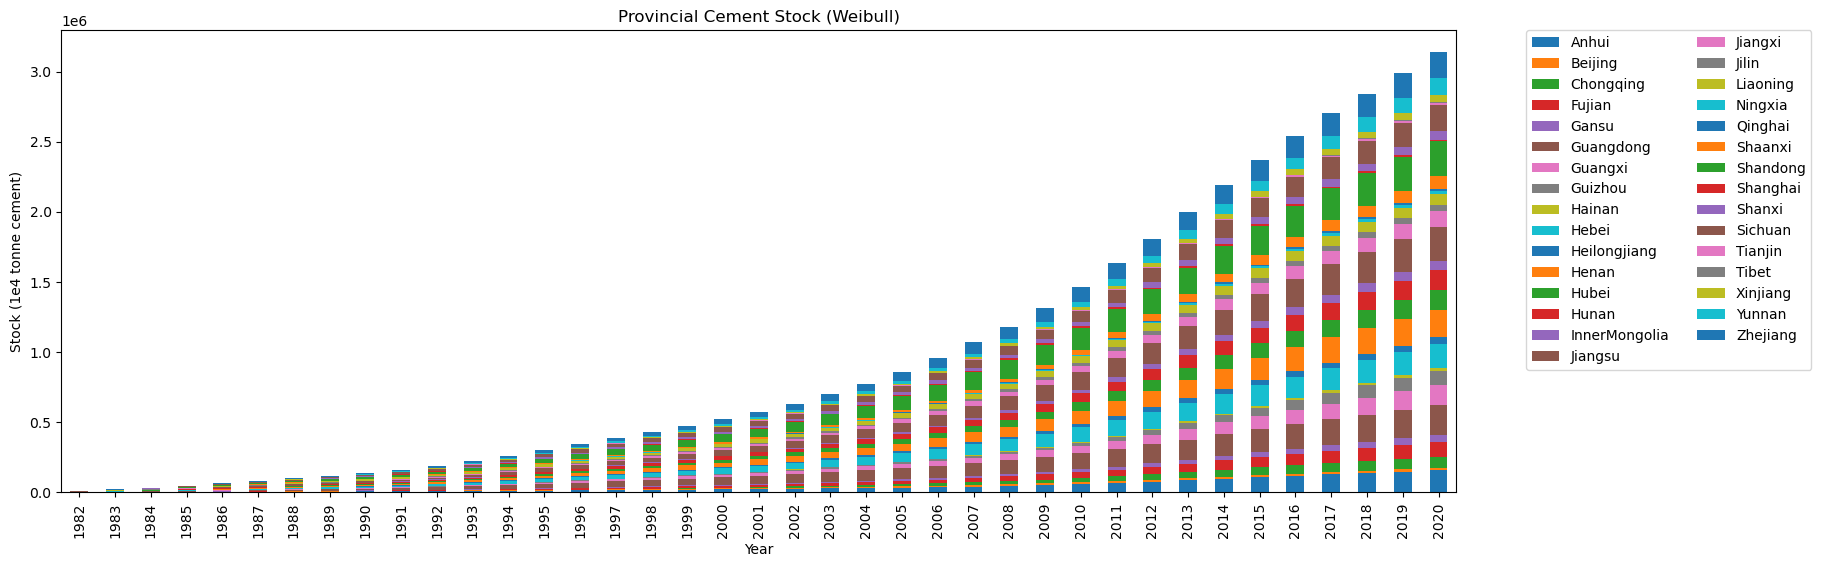

In [6]:
# plot the stock (out_s), which should be a line chart that add up all the stock in each province to national level. And color out each province.

def plot_database(df,df_title,df_ylabel):
    fig, ax = plt.subplots(figsize=(18, 6))
    df.plot(kind='bar', stacked=True, ax=ax)
    ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),ncol=2,borderaxespad = 0.)  
    ax.set_title(df_title)
    ax.set_xlabel('Year')
    ax.set_ylabel(df_ylabel)
    plt.show()
# rename the column names based on the province code
out_s_pre = out_s.copy()
out_s_pre.columns = province_code['Province']
plot_database(out_s_pre, 'Provincial Cement Stock (Weibull)','Stock (1e4 tonne cement)')
# plot_database(out_s_n, 'Provincial Cement Stock (Normal)','Stock (1e4 tonne cement)')


## Predict provincial cement stock per cap

In [7]:
pop = pd.read_excel('./data/pop/pop.xlsx', index_col = 0,usecols="A:AF", nrows=86, header=1)
# drop the first row, which have no label
pop.drop(pop.index[0], inplace=True)
# index is the year, I want to select the year from 1982 to 2020
pop_cut = pop.loc[1982:2020]
def per_capita_stock(out_s, pop_cut):
    out_s = out_s.apply(pd.to_numeric)
    pop_cut = pop_cut.apply(pd.to_numeric)
    per_cap_history = out_s / pop_cut
    return per_cap_history

per_cap_history = per_capita_stock(out_s, pop_cut)
# per_cap_history_n = per_capita_stock(out_s_n, pop_cut) 

# Calculate the national per capita stock
out_s_national = out_s.sum(axis=1)
per_cap_national = pd.DataFrame(out_s_national, columns=['National Stock'])
pop_national = pop_cut.sum(axis=1)
per_cap_national['National Population'] = pop_national
per_cap_national['Nationa PCS'] = per_cap_national['National Stock'] / per_cap_national['National Population']

per_cap_history_pre = per_cap_history.copy()
per_cap_history_pre.columns = province_code['Province']

# Adjust Jingjinji region's PCS
PCS_Jingjinji = pd.DataFrame(out_s[[2, 10, 27]].sum(axis=1), columns=['National Stock'])
PCS_Jingjinji['Jingjinji Population'] = pop_cut[[2, 10, 27]].sum(axis=1)
PCS_Jingjinji['Jingjinji PCS'] = PCS_Jingjinji['National Stock'] / PCS_Jingjinji['Jingjinji Population']

PCS_Jingjinji['BJ-HB Stock'] = out_s[[2, 10]].sum(axis=1)
PCS_Jingjinji['BJ-HB Population'] = pop_cut[[2, 10]].sum(axis=1)
PCS_Jingjinji['BJ-HB PCS'] = PCS_Jingjinji['BJ-HB Stock'] / PCS_Jingjinji['BJ-HB Population']

PCS_Jingjinji['TJ-HB Stock'] = out_s[[27, 10]].sum(axis=1)
PCS_Jingjinji['TJ-HB Population'] = pop_cut[[27, 10]].sum(axis=1)
PCS_Jingjinji['TJ-HB PCS'] = PCS_Jingjinji['TJ-HB Stock'] / PCS_Jingjinji['TJ-HB Population']

PCS_Jingjinji['Beijing PCS'] = per_cap_history[2] 
PCS_Jingjinji['Tianjin PCS'] = per_cap_history[27] 
PCS_Jingjinji['coefficient_BJ'] = PCS_Jingjinji['Beijing PCS'] / PCS_Jingjinji['BJ-HB PCS']
PCS_Jingjinji['coefficient_TJ'] = PCS_Jingjinji['Tianjin PCS'] / PCS_Jingjinji['TJ-HB PCS']


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



def train_XY_plot(X, y, city):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

    # Create and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred, )
    print(f"Mean Squared Error: {mse}")

    """
    Make predictions for future years based on a trained model, input data, and population factors.
    
    Parameters:
    model (sklearn.linear_model.LinearRegression): A trained linear regression model.
    X (pandas.DataFrame): Input data for the model.
    pop (pandas.Series): Population factors for each year.
    start_year (int): The first year to make predictions for.
    end_year (int): The last year to make predictions for.
    
    Returns:
    y_pred (pandas.Series): Predicted values for each year from start_year to end_year.
    """
    start_year = 2021
    end_year = 2060

    # Initialize the output Series
    y_pred_fut = pd.Series(index=range(start_year, end_year+1),dtype=float)

    pop_cut_pred = pop.loc[start_year:end_year]
    pop_pred = pd.DataFrame(index = range(start_year, end_year+1))
    pop_pred['pop_BJ_pred'] = pop_cut_pred[2] / pop_cut_pred[[2, 10, 27]].sum(axis=1)
    pop_pred['pop_TJ_pred'] = pop_cut_pred[27] / pop_cut_pred[[2, 10, 27]].sum(axis=1)

    # Make predictions for each year
    for year in range(start_year, end_year+1):
        if year == start_year:
            # Use the last available year as input for the first prediction
            X_input = X.loc[year-1].values.reshape(1, -1)
        
        else:
            # Use the previous year's prediction as input for subsequent predictions
            X_input = y_pred_fut[year-1]
            # Add the population factor to the input data
            if city == 'Beijing':
                X_input = [np.hstack((X_input, pop_pred['pop_BJ_pred'].loc[year]))]
                X_input = pd.DataFrame(X_input, columns=['lag1', 'pop_BJ'])
            if city == 'Tianjin':
                X_input = [np.hstack((X_input, pop_pred['pop_TJ_pred'].loc[year]))]
                X_input = pd.DataFrame(X_input, columns=['lag1', 'pop_TJ'])

        # Make the prediction   
        y_pred_fut[year] = model.predict(X_input)
    

    # Plot actual vs. predicted values
    plt.plot(X_test.index, y_test, label='Actual')
    plt.plot(X_test.index, y_pred, label='Predicted')
    plt.plot(y_pred_fut.index, y_pred_fut, label='Predicted Future')
    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel('Target')
    plt.show()

    return y_pred_fut


Mean Squared Error: 0.0003649693279610879


/Users/jerrysong/anaconda3/envs/temoa_py373/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


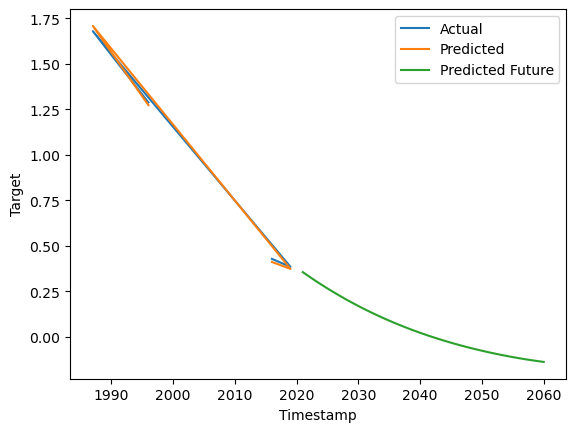

Mean Squared Error: 2.173860767336666e-05


/Users/jerrysong/anaconda3/envs/temoa_py373/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


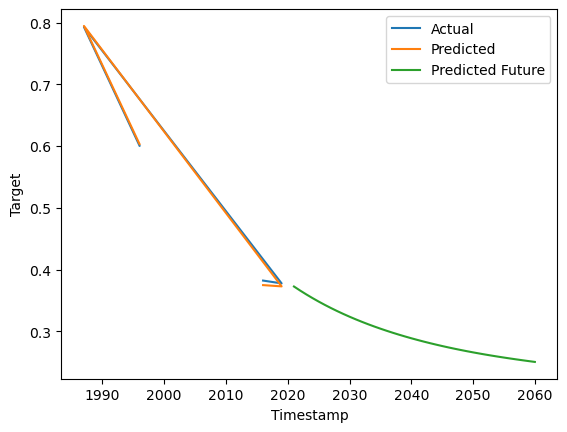

In [9]:

# Regression One
# y = Coefficient of Beijing; x = Population of Beijing
data = pd.DataFrame(index = PCS_Jingjinji.index)
data ['target'] = PCS_Jingjinji['coefficient_BJ']
data ['pop_BJ'] = pop_cut[2] / pop_cut[[2, 10]].sum(axis=1)

# Feature selection (use lagged values as features)
data['lag1'] = data['target'].shift(1)
data.dropna(inplace=True)

# Train-test split
X = data[['lag1', 'pop_BJ']]
X.columns = ['lag1', 'pop_BJ']
y = data['target']

y_pred_fut_BJ = train_XY_plot(X, y, 'Beijing')

# Regression Two
# y = Coefficient of Tiajin; x = Population of Tianjin
data = pd.DataFrame(index = PCS_Jingjinji.index)
data ['target'] = PCS_Jingjinji['coefficient_TJ']
data ['pop_TJ'] = pop_cut[27] / pop_cut[[10, 27]].sum(axis=1)

# Feature selection (use lagged values as features)
data['lag1'] = data['target'].shift(1)
data.dropna(inplace=True)

# Train-test split
X = data[['lag1', 'pop_TJ']]
X.columns = ['lag1', 'pop_TJ']
y = data['target']

y_pred_fut_TJ = train_XY_plot(X, y, 'Tianjin')




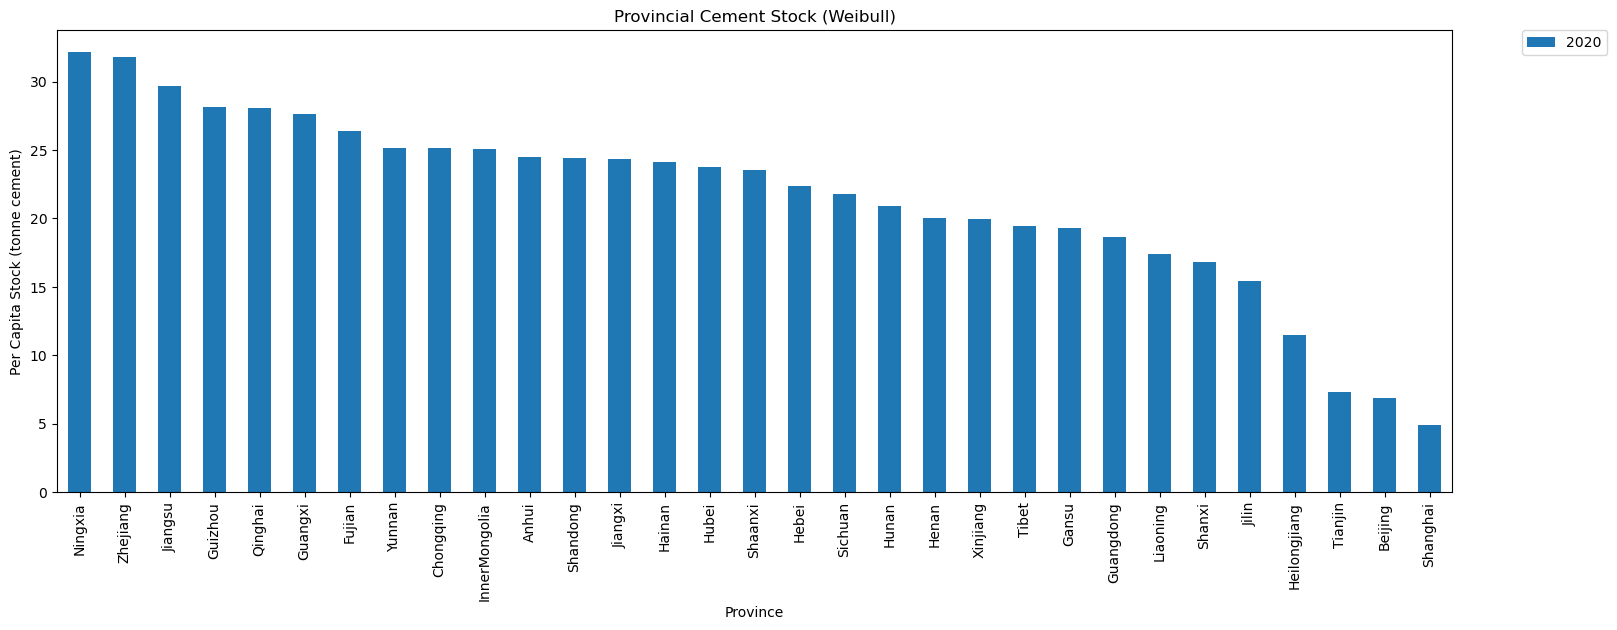

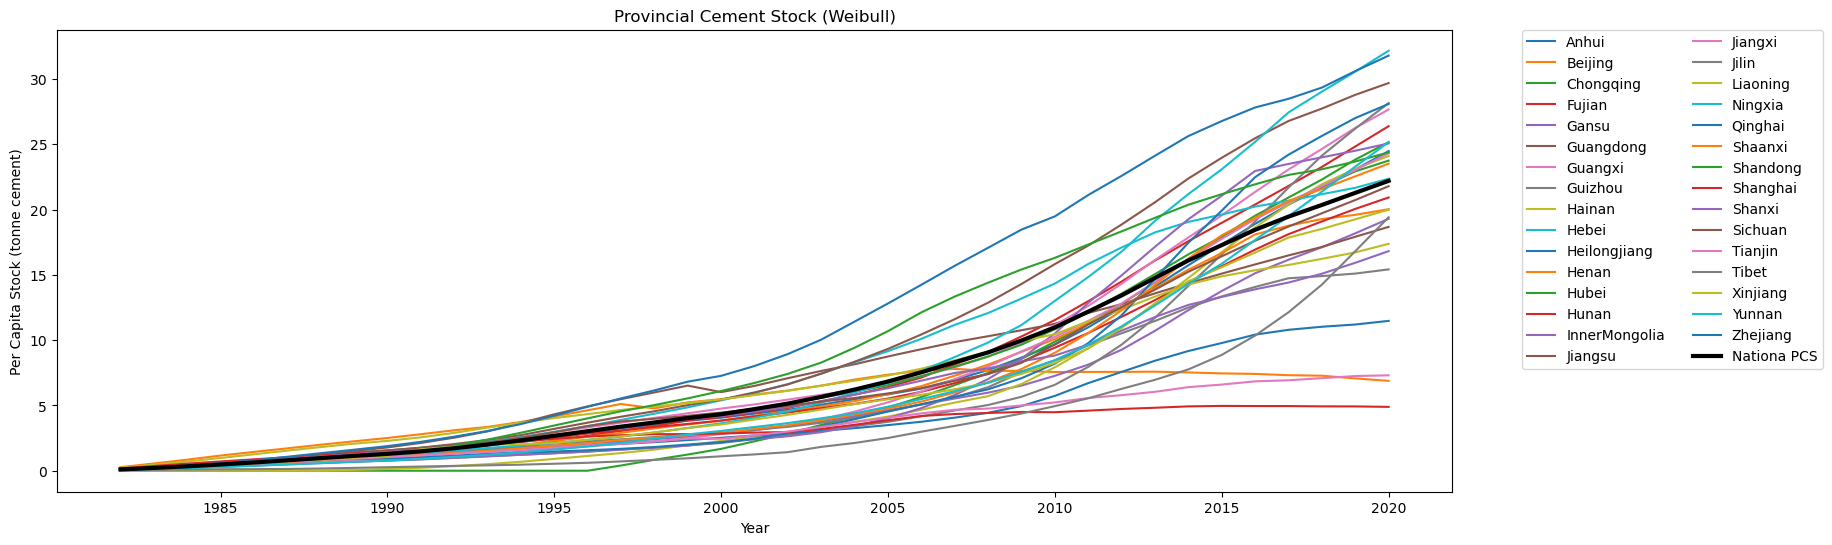

In [10]:

# draw the per capita cement stock in 2020 for each province; make the letters in the label of x-axis is horizontal
def draw_per_capita_stock(per_cap_history):
    fig, ax = plt.subplots(figsize=(18, 6))
    sorted_history = per_cap_history.loc[2020].sort_values(ascending=False)
    sorted_history.plot(kind='bar', ax=ax)
    ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),ncol=2,borderaxespad = 0.)  
    ax.set_title('Provincial Cement Stock (Weibull)')
    ax.set_xlabel('Province')
    ax.set_ylabel('Per Capita Stock (tonne cement)')
    plt.xticks(rotation=90)
    plt.show()
draw_per_capita_stock(per_cap_history_pre)
# draw_per_capita_stock(per_cap_history_n)

# draw the national per capita cement stock and provincial per capita cement stock during time periods; (set the legend outside the plot) In addition, add the per_cap_national['Per Capita Stock'] as a hightlight line.
def draw_per_capita_stock_time(per_cap_history):
    fig, ax = plt.subplots(figsize=(18, 6))
    per_cap_history.plot(ax=ax)
    per_cap_national['Nationa PCS'].plot(ax=ax, color='black', linewidth=3)
    ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),ncol=2,borderaxespad = 0.)  
    ax.set_title('Provincial Cement Stock (Weibull)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Per Capita Stock (tonne cement)')
    plt.show()

draw_per_capita_stock_time(per_cap_history_pre)

<img src="./Requirments/system_digram/per_cap_function.png" width="790" height="470" alt="per cap function">

/Users/jerrysong/anaconda3/envs/temoa_py373/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


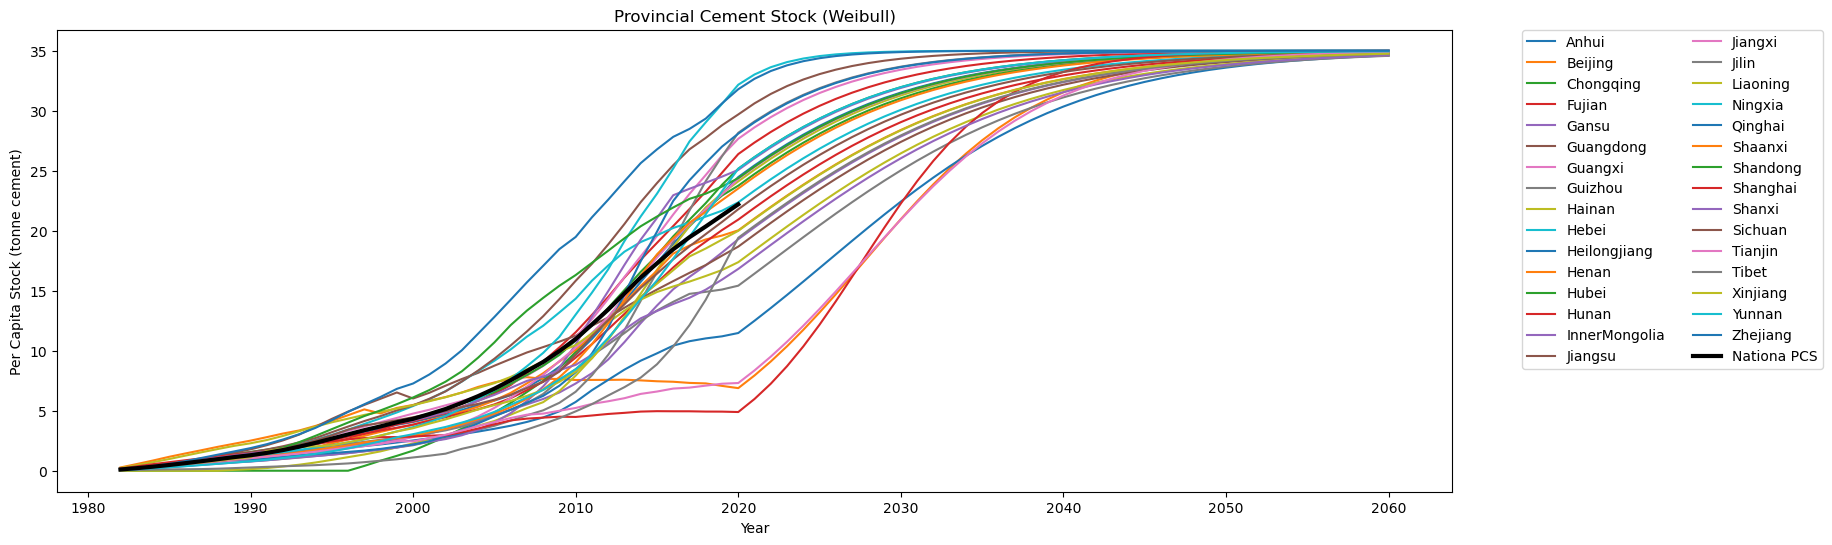

In [11]:
#c_0 =          # per-cap cement stock in 2020;
#d_0 =          # per-cap cement stock changed from 2019 to 2020;
#t_0            # the begining year of prediction (2020);
#s_level =      # the saturation level of per-cap cement stock provincial level;
def per_cap_prediction(c_0,d_0,t_0,s_level,t_f):
    d_0_1 = d_0
    d_0_2 = (s_level-c_0)/(2060-2020)
    d_0 = d_0_1*0.6 + d_0_2*0.4
    s_p = (s_level)/(1+((s_level/c_0)-1)*math.exp((-(s_level)/(c_0*(s_level-c_0)))*(t_f-t_0)))
    return s_p

def predict_PCS(num_prov,per_cap_history,s_level):
    predicted_PCS = per_cap_history.copy()
    for prov in range(1, num_prov+1):
        for year in range(2021, 2061):
            if year not in predicted_PCS.index:
                predicted_PCS.loc[year] = pd.Series(index=predicted_PCS.columns)
            predicted_PCS.loc[year][prov] = per_cap_prediction(predicted_PCS.loc[2020][prov], predicted_PCS.loc[2020][prov]-predicted_PCS.loc[2019][prov], 2020, s_level.loc[prov], year)
    return predicted_PCS

s_level = pd.DataFrame({'Value': 35}, index=range(1, 32))
predicted_PCS = predict_PCS(31,per_cap_history,s_level)

predicted_PCS_pre = predicted_PCS.copy()
predicted_PCS_pre.columns = province_code['Province']
draw_per_capita_stock_time(predicted_PCS_pre)

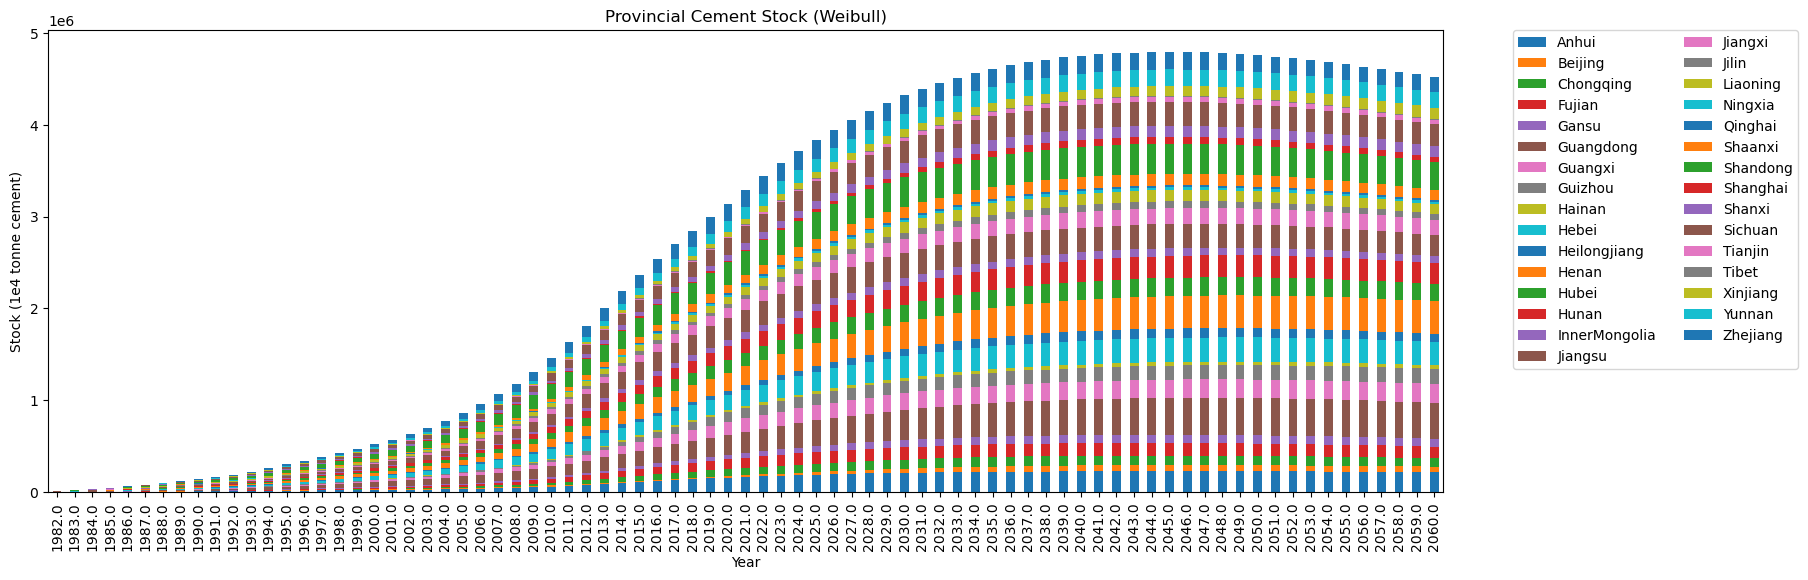

In [12]:
pop_cut_long = pop.loc[1982:2060]
def total_capita_stock(predicted_PCS, pop_cut_long):
    predicted_PCS = predicted_PCS.apply(pd.to_numeric)
    # align the index of predicted_PCS
    predicted_PCS = predicted_PCS.reindex(pop_cut_long.index)
    pop_cut_long = pop_cut_long.apply(pd.to_numeric)
    stock_predicted = predicted_PCS * pop_cut_long
    return stock_predicted

total_stock = total_capita_stock(predicted_PCS, pop_cut_long)

total_stock_pre = total_stock.copy()
total_stock_pre.columns = province_code['Province']
plot_database(total_stock_pre, 'Provincial Cement Stock (Weibull)','Stock (1e4 tonne cement)')

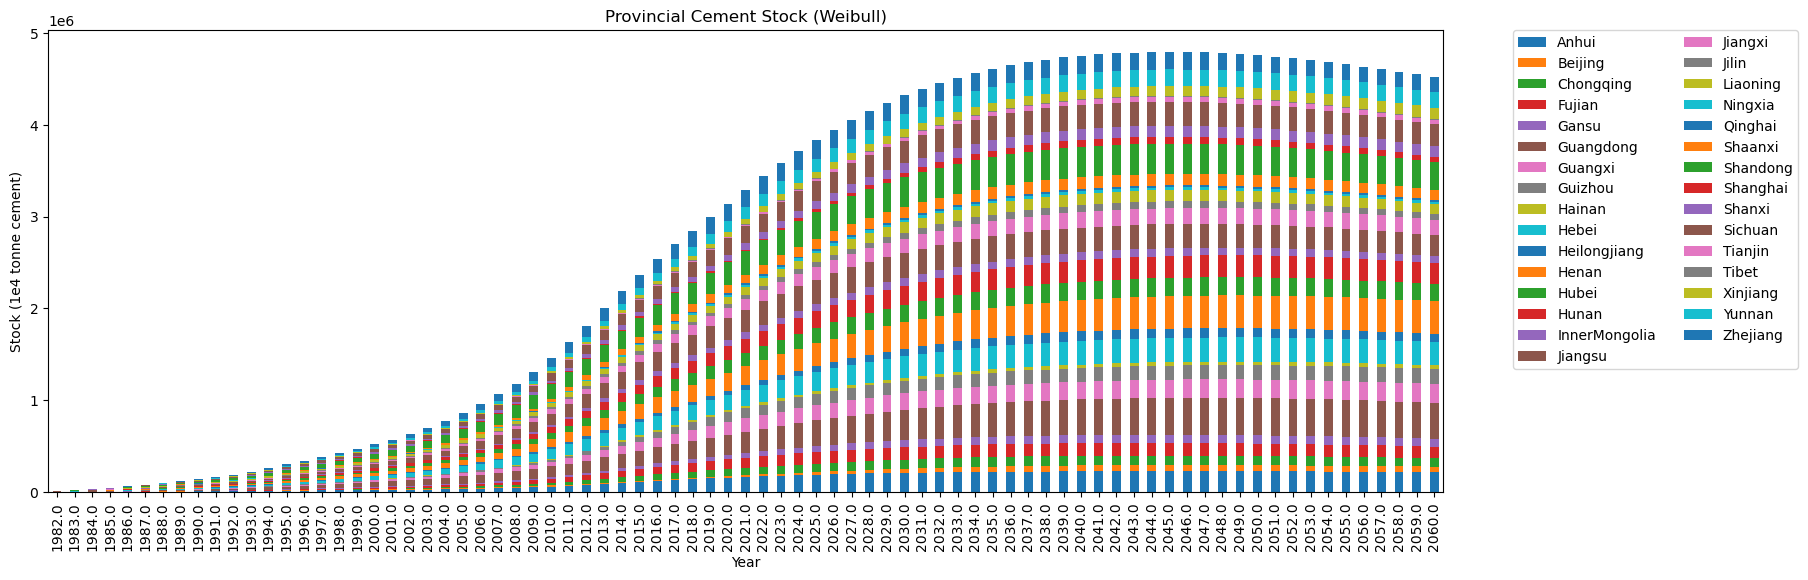

In [ ]:
pop_cut_long = pop.loc[1982:2060]
def total_capita_stock(predicted_PCS, pop_cut_long):
    predicted_PCS = predicted_PCS.apply(pd.to_numeric)
    # align the index of predicted_PCS
    predicted_PCS = predicted_PCS.reindex(pop_cut_long.index)
    pop_cut_long = pop_cut_long.apply(pd.to_numeric)
    stock_predicted = predicted_PCS * pop_cut_long
    return stock_predicted

total_stock = total_capita_stock(predicted_PCS, pop_cut_long)

total_stock_pre = total_stock.copy()
total_stock_pre.columns = province_code['Province']
plot_database(total_stock_pre, 'Provincial Cement Stock (Weibull)','Stock (1e4 tonne cement)')

## From Predicted Stock to Predicted inflow

In [13]:
# define a function for calculating cement production from predicted cement stock
def from_stock_to_inflow_outflow(dis_type, shape_stddev, scale_mean, strat_year, num_year, num_prov, stock):            # length is the number of years in the entire period
    out_oc_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns =  pd.MultiIndex.from_product([list(range(1,num_prov+1)), list(range(strat_year,strat_year+num_year))]))  # Multi-index columns (region & years), to contain a matrix of years*years for each region
    out_i_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    out_s_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    out_o_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    idx = pd.IndexSlice
    
    for prov in range(1,num_prov+1):

        stock_prov = stock.iloc[prov-1].values
        if dis_type == 'Weibull':  
            shape_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            scale_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), s =  np.array(stock_prov), lt = {'Type': 'Weibull', 'Shape': np.array(shape_list), 'Scale': np.array(scale_list)})
        elif dis_type == 'Normal':
            stddev_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            mean_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), s =  np.array(stock_prov), lt = {'Type': 'Normal', 'Mean': np.array(mean_list), 'StdDev': np.array(stddev_list)}) # shape & scale list are actually Mean & StDev here

        
        out_sc, out_oc, out_i = DSMforward.compute_stock_driven_model(NegativeInflowCorrect = True)
        
        out_i_reg[prov] = out_i        
        out_oc[out_oc < 0] = 0 # remove negative outflow, replace by 0
        out_oc_reg.loc[:,idx[prov,:]]  = out_oc
        
        # If you are only interested in the total outflow, you can sum the outflow by cohort
        out_o_reg[prov] = out_oc.sum(axis = 1)
        out_o_reg_corr = out_o_reg._get_numeric_data()        
        out_o_reg_corr[out_o_reg_corr < 0] = 0            
        out_s_reg[prov] = out_sc.sum(axis = 1) #Stock 
        
    return out_i_reg, out_oc_reg

In [14]:
def trans_df(df):
    pivoted = pd.DataFrame(index=df.columns, columns=df.index)
    for year in df.columns:
        for prov in df.index:
            pivoted.loc[year, prov] = df.loc[prov, year]
    return pivoted

total_stock_pivoted = trans_df(total_stock)

out_i_reg, out_oc_reg = from_stock_to_inflow_outflow('Weibull',1.5, 25, 1982, 79, 31, total_stock_pivoted)

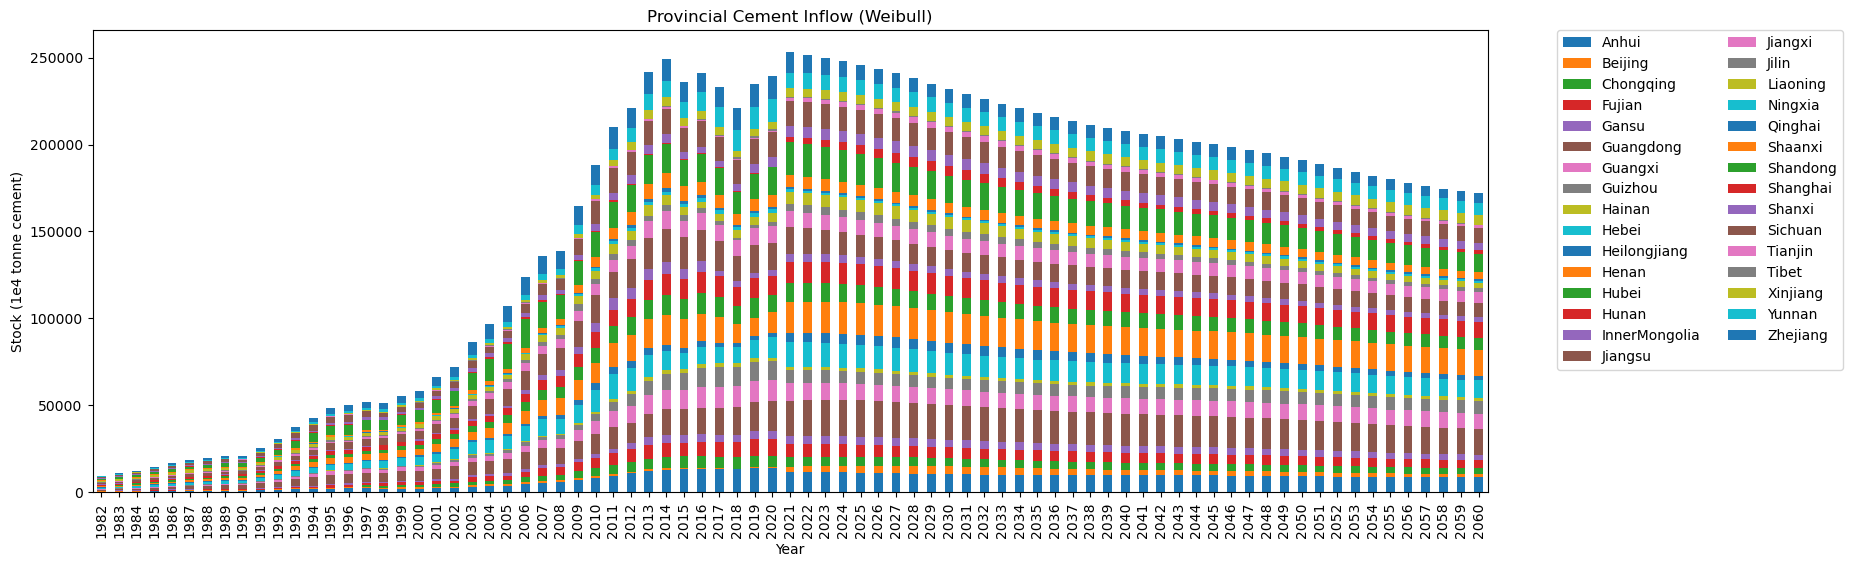

In [15]:
out_i_reg_pre = out_i_reg.copy()
out_i_reg_pre.columns = province_code['Province']
plot_database(out_i_reg_pre, 'Provincial Cement Inflow (Weibull)','Stock (1e4 tonne cement)')